Author: Qing Zhao
Student ID: 230161210

# project summary:
1.  **Data Description and Data Source:** The dataset comes from Kaggle (https://www.kaggle.com/datasets/tanishqdublish/text-classification-documentation), containing 2225 text data and five categories of documents (politics, sport, tech, entertainment, and business).
2.  **Problem Formula:** Traditional machine learning methods and neural network models are used to solve text classification and text clustering tasks
3.  **Applied Techniques:** LSTM, Multinomial Naive Bayes, K-Means, tokenizer, tfidfvector, countvector, embedding, PCA, various model evaluation metrics, and data visualization methods.
4.  **Project Results:** In the text classification task, both the LSTM model and the Naive Bayes model perform well in the test dataset, achieving accuracy of 0.94 and 0.93, respectively, indicating good generalization ability. As for the clustering task, I use the K-means method for clustering, the Silhouette Coefficient and Calinski_Harabasz are 0.067 and 292.83, respectively. After using principal component analysis to reduce the dimension to two dimensions for data visualization, we can see that the clustering is effective.

# Import dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Data Exploration

In [ ]:
df=pd.read_csv("/content/df_file.csv")

In [ ]:
df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [ ]:
df.shape

(2225, 2)

In [ ]:
# check how the distribution of classes
counts=df['Label'].value_counts(True)
print(counts)

Label
1    0.229663
4    0.229213
0    0.187416
2    0.180225
3    0.173483
Name: proportion, dtype: float64


In [ ]:
classes= {
    0:'Politics',
    1:'Sport',
    2:'Technology',
    3:'Entertainment',
    4:'Business'
}

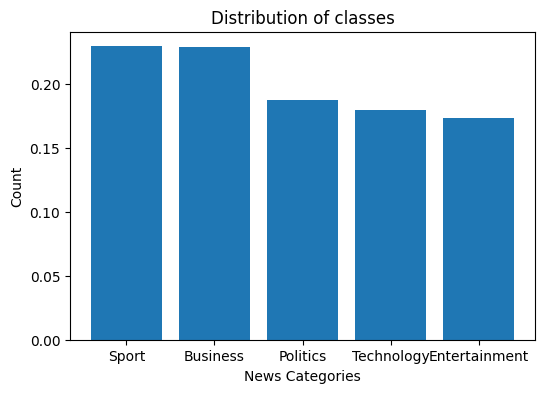

In [ ]:
# exploring the distribution of news categories

from matplotlib import pyplot as plt
x=[classes[i] for i in counts.index]
y=counts.values
plt.figure(figsize=(6,4))
plt.bar(x,y)
plt.xlabel("News Categories")
plt.ylabel("Count")
plt.title("Distribution of classes")
plt.show()

# Data Preprocessing

In [ ]:
# replace "\n" with " " in the text
df['Text'] = df['Text'].apply(lambda x:x.replace('\n',''))

In [ ]:
def preprocessing_text(text):
    text= text.lower()
    text = text.split()
    text = ' '.join(text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text= re.sub(r'\s+', ' ', text)
    return text

In [ ]:
df['Text'] = df['Text'].apply(lambda x:preprocessing_text(x))

# 1. Text Classification Task

### split training and text dataset

In [ ]:
from sklearn.model_selection import train_test_split

X=df['Text']
y=df['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
text_lengths = X_train.apply(lambda x: len(x.split()))

In [ ]:
# check the lens of texts
df=pd.Series(text_lengths)
df.describe()

,Text
count,1780.000000
mean,378.166292
std,224.067723
min,88.000000
25%,240.000000
50%,330.000000
75%,465.250000
max,3400.000000


## 1.1 method_LSTM

### define global  variate

In [ ]:
class Global_Var:
  max_length=300
  embedding_dim=16

### tokenize the training and text dateset

In [ ]:
X_train_copy=X_train.copy()

In [ ]:
# tokenizer the texts

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length=300

tokenizer_texts=Tokenizer(oov_token="<OOV>")
tokenizer_texts.fit_on_texts(X_train)
train_texts=tokenizer_texts.texts_to_sequences(X_train)
X_train_tokens=pad_sequences(train_texts,padding="post",maxlen=Global_Var.max_length,truncating="post")

In [ ]:
word_index=tokenizer_texts.word_index
print(f"numbers of words in word_index:{len(word_index)}")

numbers of words in word_index:28486


In [ ]:
print(f"the original text:{X_train[0]}")
print(f"the tokenized text:{train_texts[0]}")
print(f"the padded text:{X_train_tokens[0]}")

the original text:budget to set scene for election gordon brown will seek to put the economy at the centre of labours bid for a third term in power when he delivers his ninth budget at gmt he is expected to stress the importance of continued economic stability with low unemployment and interest rates the chancellor is expected to freeze petrol duty and raise the stamp duty threshold from â but the conservatives and lib dems insist voters face higher taxes and more meanstesting under labour treasury officials have said there will not be a preelection giveaway but mr brown is thought to have about âbn to spare increase in the stamp duty threshold from â a freeze on petrol duty an extension of tax credit scheme for poorer families possible help for pensioners the stamp duty threshold rise is intended to help first time buyers a likely theme of all three of the main parties general election manifestos ten years ago buyers had a much greater chance of avoiding stamp duty with close to half 

In [ ]:
print(f"X_train shape:{X_train_tokens.shape}\ny_test shape:{y_train.shape}")

X_train shape:(1780, 300)
y_test shape:(1780,)


In [ ]:
test_texts=tokenizer_texts.texts_to_sequences(X_test)
X_test_tokens=pad_sequences(test_texts,padding="post",maxlen=Global_Var.max_length,truncating="post")

In [ ]:
print(f"X_test shape:{X_test_tokens.shape}\ny_test shape:{y_test.shape}")

X_test shape:(445, 300)
y_test shape:(445,)


### build a LSTM model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

vocal_size=len(word_index)+1
print(f"vocal_size:{vocal_size}")

vocal_size:28487


In [ ]:
#define a callback
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get("accuracy")>0.99:
      print("\nreached val_accuracy higher than 0.99,cancelling the process!")
      self.model.stop_training=True

mycallback=mycallback()

In [ ]:
# define a LSTM model

def LSTM_model():
  model=Sequential()
  model.add(layers.Embedding(vocal_size,Global_Var.embedding_dim))
  model.add(layers.Bidirectional(layers.LSTM(32)))

  model.add(layers.Dense(128,activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(5,activation="softmax"))

  return model


In [ ]:
LSTM_model=LSTM_model()
LSTM_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
LSTM_history=LSTM_model.fit(X_train_tokens,y_train,epochs=15,batch_size=64,verbose=2,callbacks=[mycallback])

Epoch 1/15
28/28 - 12s - 418ms/step - accuracy: 0.2438 - loss: 1.5885
Epoch 2/15
28/28 - 9s - 304ms/step - accuracy: 0.3871 - loss: 1.4887
Epoch 3/15
28/28 - 10s - 364ms/step - accuracy: 0.6034 - loss: 1.1061
Epoch 4/15
28/28 - 10s - 365ms/step - accuracy: 0.7461 - loss: 0.7148
Epoch 5/15
28/28 - 11s - 410ms/step - accuracy: 0.8708 - loss: 0.4514
Epoch 6/15
28/28 - 11s - 383ms/step - accuracy: 0.9281 - loss: 0.2554
Epoch 7/15
28/28 - 6s - 202ms/step - accuracy: 0.9545 - loss: 0.1695
Epoch 8/15
28/28 - 7s - 257ms/step - accuracy: 0.9764 - loss: 0.0963
Epoch 9/15
28/28 - 6s - 209ms/step - accuracy: 0.9854 - loss: 0.0547
Epoch 10/15
28/28 - 7s - 233ms/step - accuracy: 0.9539 - loss: 0.1532
Epoch 11/15
28/28 - 6s - 231ms/step - accuracy: 0.9893 - loss: 0.0652
Epoch 12/15

reached val_accuracy higher than 0.99,cancelling the process!
28/28 - 11s - 401ms/step - accuracy: 0.9961 - loss: 0.0318


In [ ]:
LSTM_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 300, 16)             │         455,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,431,905 (5.46 MB)

 Trainable params: 477,301 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,604 (3.64 MB)

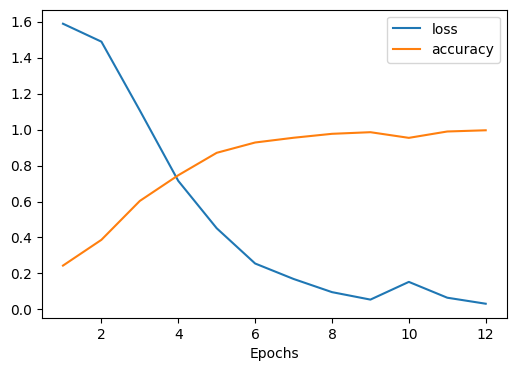

In [ ]:
import matplotlib.pyplot as plt

epochs=range(1,len(LSTM_history.history["loss"])+1)

plt.figure(figsize=(6,4))
plt.plot(epochs,LSTM_history.history["loss"])
plt.plot(epochs,LSTM_history.history["accuracy"])
plt.xlabel("Epochs")
#plt.ylabel(["loss","accuracy"])
plt.legend(["loss","accuracy"])
plt.show()

### prediction and evaluation

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
accuracy:0.9393258426966292

classification_report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93        92
           1       1.00      0.97      0.98        98
           2       0.81      0.96      0.88        77
           3       0.96      0.95      0.95        76
           4       0.96      0.93      0.95       102

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445



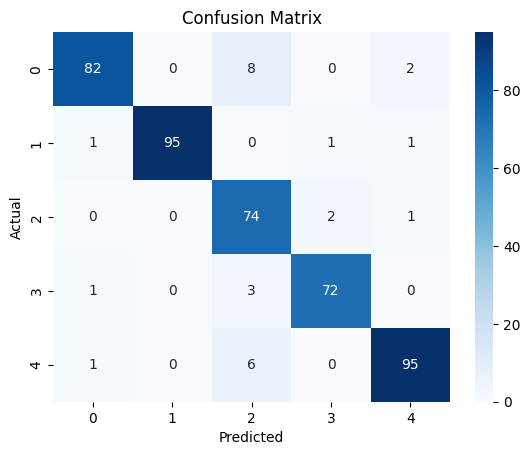

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns
import numpy as np

y_pred=LSTM_model.predict(X_test_tokens)
y_pred=np.argmax(y_pred,axis=1)

acc=accuracy_score(y_test,y_pred)
print(f"accuracy:{acc}\n")
print(f"classification_report:\n{classification_report(y_test,y_pred)}")

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 1.2 method_ Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### TF-IDF Vectorizer

In [ ]:
tfidf = TfidfVectorizer()

X_train_tfidfVector = tfidf.fit_transform(X_train)
X_test_tfidfVector = tfidf.transform(X_test)

In [ ]:
X_train_tfidfVector[0]

<1x28459 sparse matrix of type '<class 'numpy.float64'>'
	with 209 stored elements in Compressed Sparse Row format>

### build a MultinomialNB model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

MultinomialNB_model = MultinomialNB()
MultinomialNB_model.fit(X_train_tfidfVector, y_train)

MultinomialNB()

In [ ]:
pred=MultinomialNB_model.predict(X_train_tfidfVector)
acc=accuracy_score(y_train,pred)
print(f"the accuracy of training:{acc}\n")

the accuracy of training:0.9837078651685394



### prediction and evaluation

accuracy:0.9348314606741573

classification_report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        92
           1       0.92      1.00      0.96        98
           2       0.95      0.92      0.93        77
           3       0.97      0.84      0.90        76
           4       0.92      0.96      0.94       102

    accuracy                           0.93       445
   macro avg       0.94      0.93      0.93       445
weighted avg       0.94      0.93      0.93       445



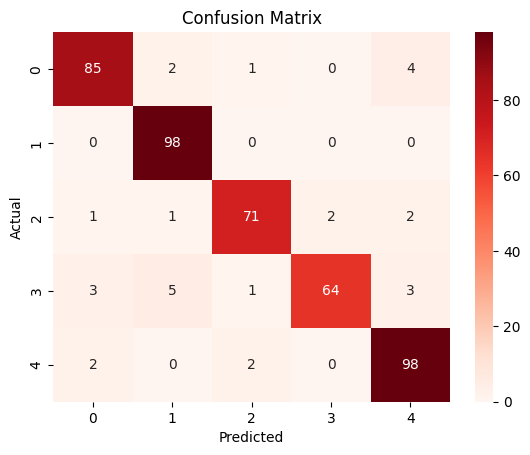

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns
import numpy as np

y_pred=MultinomialNB_model.predict(X_test_tfidfVector)

acc=accuracy_score(y_test,y_pred)
print(f"accuracy:{acc}\n")
print(f"classification_report:\n{classification_report(y_test,y_pred)}")

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# 2. Text Clustering Task

## build a K-means model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
X_countvector= CountVectorizer().fit_transform(X).toarray()

In [ ]:
from sklearn.cluster import KMeans

Kmeans_model= KMeans(n_clusters=5, random_state=2024)
Kmeans_model.fit(X_countvector)


# Predict the cluster labels for each data point
labels=Kmeans_model.predict(X_countvector)

# Get the cluster centers
centroids = Kmeans_model.cluster_centers_

# Print the cluster labels and centroids
print("Cluster labels:", labels)
print("Cluster centers:\n", centroids)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster labels: [0 0 0 ... 4 4 4]
Cluster centers:
 [[ 2.20750552e-03  1.51788304e-17  1.98675497e-02 ...  2.31788079e-01
   7.58941521e-18  2.81892565e-18]
 [ 1.30104261e-18  8.92857143e-03  3.57142857e-02 ...  2.14285714e-01
   1.78571429e-02  1.30104261e-18]
 [ 3.03576608e-18  4.48933782e-03  4.48933782e-03 ...  3.32210999e-01
   1.12233446e-03  3.03576608e-18]
 [ 0.00000000e+00 -4.33680869e-19  0.00000000e+00 ...  2.85714286e-01
  -2.16840434e-19  0.00000000e+00]
 [ 2.98155597e-18  1.31233596e-03  1.31233596e-03 ...  2.13910761e-01
   5.63785130e-18  1.31233596e-03]]


## visulize clustering results

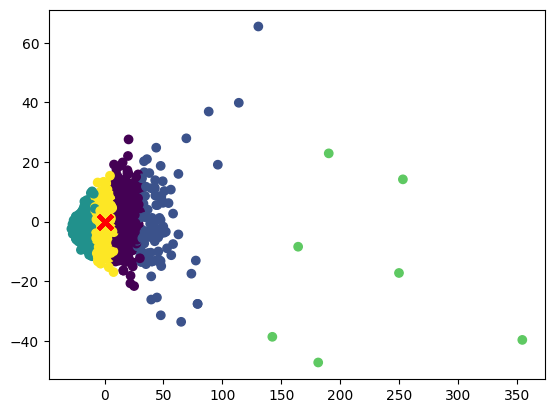

In [ ]:
from sklearn.decomposition import PCA
# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_countvector)

# Visualize clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Kmeans_model.labels_, cmap='viridis')
plt.scatter(Kmeans_model.cluster_centers_[:, 0], Kmeans_model.cluster_centers_[:, 1], marker='x', s=100, linewidths=3, color='r')
plt.show()

## evaluation

#### **Silhouette Coefficient:** Measures how similar a data point is to its own cluster compared to other clusters. A higher silhouette coefficient indicates better-defined clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(X_countvector, labels)
print("Silhouette coefficient:", silhouette_avg)

Silhouette coefficient: 0.06665647939919095


#### **Calinski_Harabasz:**Compares the ratio of the sum of between-clusters dispersion and within-cluster dispersion

In [ ]:
from sklearn.metrics import calinski_harabasz_score
# Calculate calinski_harabasz
calinski_harabasz = calinski_harabasz_score(X_countvector, labels)
print("Calinski-Harabasz Index:", calinski_harabasz)

Calinski-Harabasz Index: 292.8275786162426


#### **Within-Cluster Sum of Squares (WCSS)**: Measures the compactness of clusters. A lower WCSS indicates better clustering.

In [ ]:
def calculate_wcss(X, labels):
  n_clusters = len(np.unique(labels))
  wcss = 0

  for i in range(n_clusters):
    cluster_points = X[labels == i]
    centroid = np.mean(cluster_points, axis=0)
    wcss += np.sum((cluster_points - centroid) ** 2)

  return wcss

# calculate wcss_value
wcss_value = calculate_wcss(X_countvector, labels)
print("Within-Cluster Sum of Squares (WCSS):", wcss_value)

Within-Cluster Sum of Squares (WCSS): 1675420.5438154559
